# Lab 10 - Vanilla CNN and Fine-Tune VGG16 - for Dogs and Cats Classification

## Introduction

The main aim of this lab is to train a Vanilla CNN and Fine-Tune the pre-trained VGG16 base model to classify Dogs and Cats. We will use the Cats vs Dogs Dataset from Kaggle. The original dataset in kaggle consists of 25,000 images for Training. Out of those 25,000 images we are going to use only a small portion of dataset consisting of 3000 images. 2000 images for training, 1000 images for validation and 2000 images for testing. Both the classes Cats and dogs consists of equal number of images during training, validation and testing. The Class of Cats has a label of 0 and Dogs has label 1.

In [45]:
# Importing the libraries
from tensorflow.keras.datasets import fashion_mnist
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import pandas as pd
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory
import seaborn as sns
from sklearn.metrics import accuracy_score,confusion_matrix, precision_score, recall_score, f1_score,classification_report,precision_recall_curve

In [4]:
# Folder path to the dataset
data_folder = pathlib.Path('data\kaggle_dogs_vs_cats_small')

In [5]:
# Loading the images directly from the directory with labels as 0 and 1 in batch size of 32. Also we will resize the image to height and width of 180X180
train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [6]:
# Printing the type of the training dataset
type(train_dataset)

tensorflow.python.data.ops.batch_op._BatchDataset

In [7]:
# Printing the shape of the input Image Data and corresponding images
for data_batch, labels_batch in train_dataset:
    print("Image data batch shape:", data_batch.shape)
    print("Labels batch shape:", labels_batch.shape)
    break

Image data batch shape: (32, 180, 180, 3)
Labels batch shape: (32,)


In [8]:
# labels of images in first batch - labels are of type integer 32 bits
labels_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 1])>

## Data Exploration
### Visualizing first batch of 32 images in the training dataset

In some images we can see that, there are **two or three dogs/cats** in the same image. Also the images include the surrounding environment, other objects as well as humans. **Each image is 180X180 pixels with three channels RGB**

In [9]:
# Creating a list of label description
label_description = ["Cat","Dog"]

In [10]:
# To plot the images along with labels
def plot_images(image_data,label):
    plt.imshow(image_data.numpy().astype("uint8"))
    plt.title(f"{label}-{label_description[label]}", fontsize=8)
    plt.axis("off")

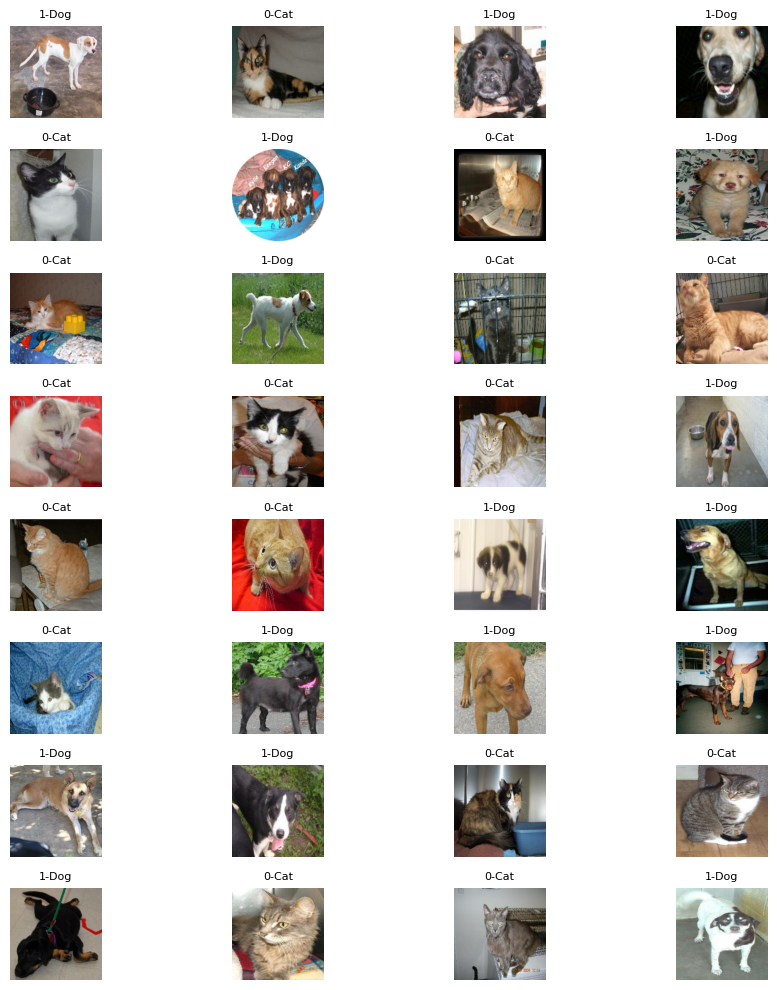

In [11]:
# Displaying the first batch - 32 images along with class description 
plt.figure(figsize=(10, 10))
for idx, image_data in enumerate(data_batch):
    plt.subplot(8, 4, idx + 1)
    plot_images(image_data,labels_batch[idx])
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.show()

## Distribution of pixel values of all images in training set

The below histogram shows **the intensity of pixel values for the three color channels red, blue and green across all images** in the training dataset.

In each channel, the **highest pixel value of 255 denotes the dominance of that particular color channel**. From the plot, we can find that **color channel red has high dominance when compared to green and blue**.

In [12]:
# Initializing empty dictionary to store all the training, validation and testing images along with labels
dataset_labels = {}
dataset_images = {}

In [13]:
# Function to get the total number of images and labels
def getImageCount(dataset,dataset_name):
    label_batches = []
    image_batches = []
    for image_batch, label_batch in dataset:
        label_batches.append(label_batch.numpy())
        image_batches.append(image_batch.numpy().astype("uint8"))
    label_batches = np.concatenate(label_batches)
    image_batches = np.concatenate(image_batches)
    dataset_images[dataset_name] = image_batches
    dataset_labels[dataset_name] = label_batches


In [14]:
getImageCount(train_dataset,"Training")
getImageCount(validation_dataset,"Validation")
getImageCount(test_dataset,"Testing")

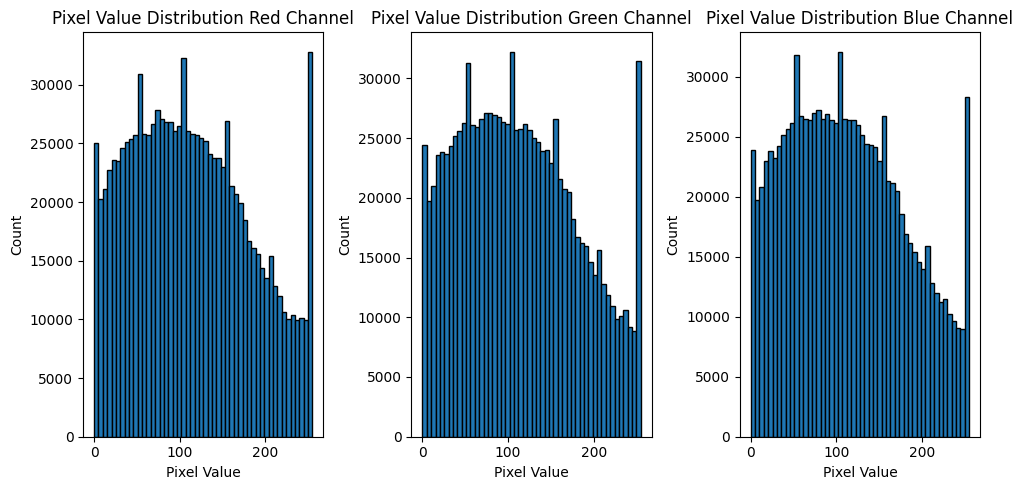

In [15]:
# Plot the distribution of pixel values of all images in training dataset
fig = plt.figure(figsize=(10, 5))
all_training_images = dataset_images['Training']
# subplot the distribution of pixel values in red channel of all images in training dataset
plt.subplot(1, 3, 1)
plt.hist(all_training_images[:,:,0].ravel(),  bins=50,edgecolor='black')
plt.title('Pixel Value Distribution Red Channel')
plt.xlabel('Pixel Value')
plt.ylabel('Count')
# subplot the distribution of pixel values in green channel of all images in training dataset
plt.subplot(1, 3, 2)
plt.hist(all_training_images[:,:,1].ravel(),  bins=50,edgecolor='black')
plt.title('Pixel Value Distribution Green Channel')
plt.xlabel('Pixel Value')
plt.ylabel('Count')
# subplot the distribution of pixel values in blue channel of all images in training dataset
plt.subplot(1, 3, 3)
plt.hist(all_training_images[:,:,2].ravel(),  bins=50,edgecolor='black')
plt.title('Pixel Value Distribution Blue Channel')
plt.xlabel('Pixel Value')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [86]:
img = data_batch[0].numpy().shape
label = labels_batch[0]

In [92]:
def visualize_input(channel,color):
    fig = plt.figure(figsize = (12,12)) 
    ax = fig.add_subplot(111)
    img_channel = img[:,:,channel]
    ax.imshow(img[:,:,0])
    ax.set_title(f"{label}-{label_description[label]}")
    width, height = img_channel.shape
    thresh = img_channel.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(img_channel[x][y]), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color=color if img_channel[x][y]<thresh else 'black',fontsize ='8')
    ax.set_xticks([])
    ax.set_yticks([])

### Bar plot to show the distribution of images of both classes in training, testing and validation set.

From the graph, it is evident that **there are equal number of images in both the classes**. The **dataset is class balanced with 0 skewness.**

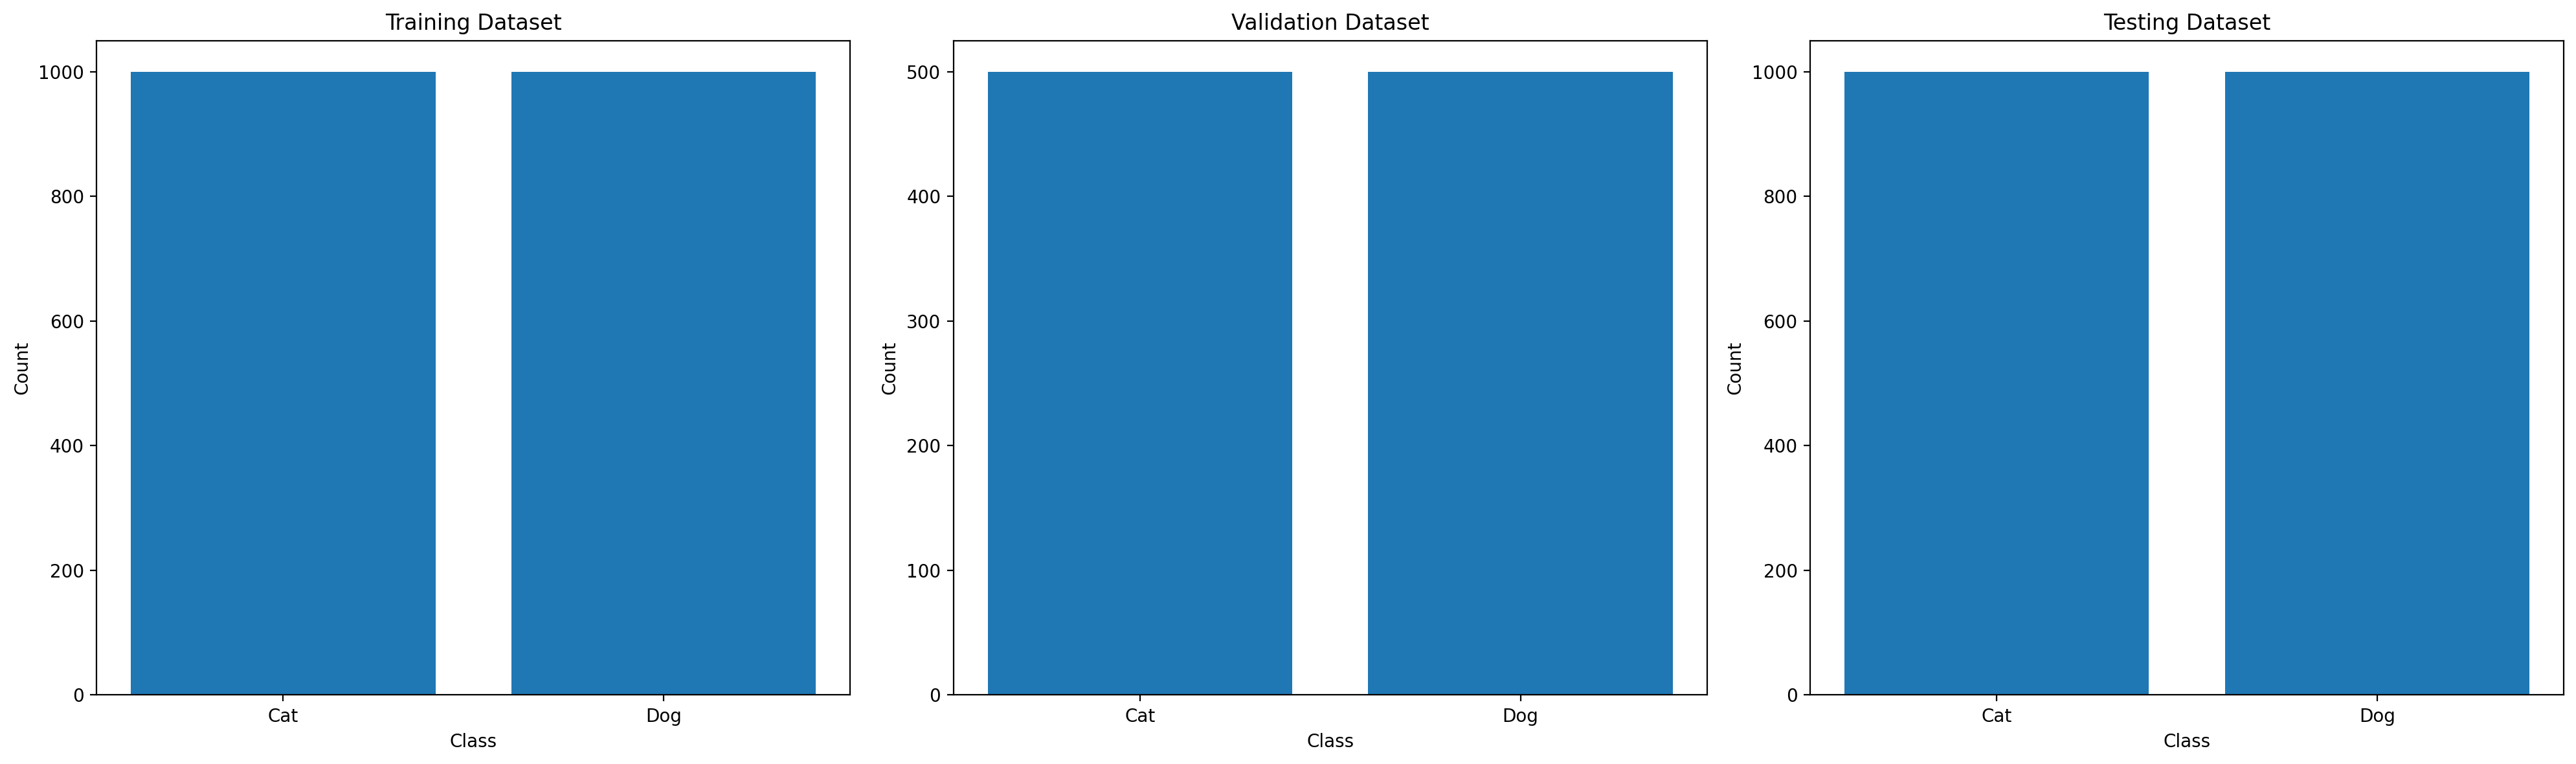

In [16]:
# Count the occurrences of each class in training, validation and testing dataset
plt.figure(figsize=(20, 6),dpi=200)
for index, (dataset_name,data_labels) in enumerate(dataset_labels.items()):
    plt.subplot(1, 3, index+1)
    counts = np.bincount(data_labels)
    plt.bar(label_description, counts)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(f'{dataset_name} Dataset')
    plt.tight_layout()

## Data Pre-processing

### Data Augmentation

**Data Augmentation** is a **technique used to artificially increase the size of the dataset by applying random transformations to images such as image rotation, zooming etc**. Here we have used **keras pre-processing layers such as RandomFlip, RandomRotation and RandomZoom**.

In [93]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.3),
    ]
)

### Displaying the images after performing Data augmentation

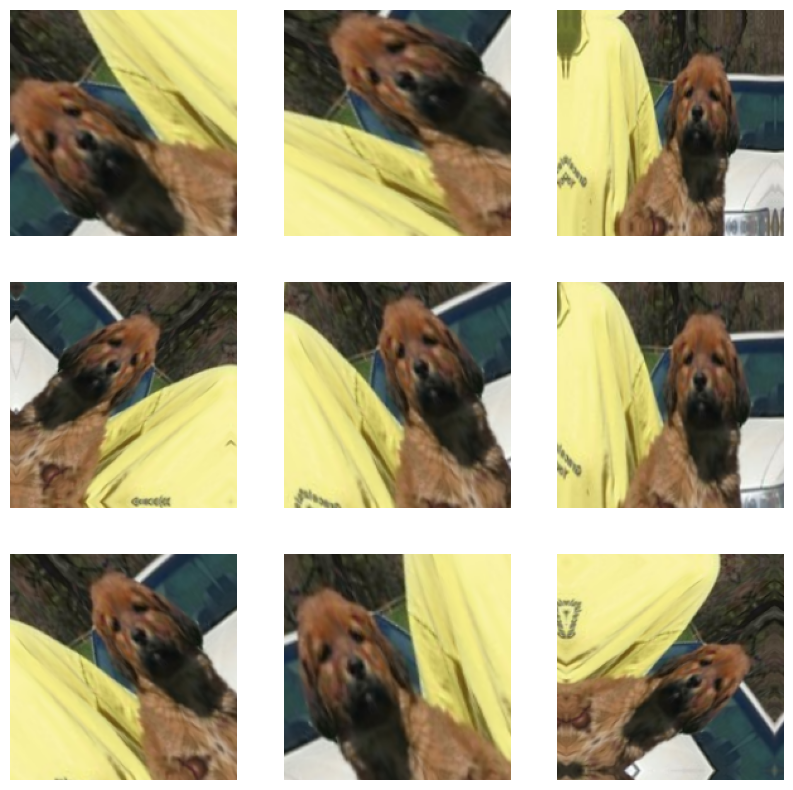

In [95]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(2):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Modeling

Here we are going to train two models 
 - Vanilla (Convolutional Neural Network)CNN
 - Fine Tuning VGG-16 pre-trained model

### Specification of Vanilla CNN

1. The **Vanilla CNN** consists of **Input layer, Data Augmentation layer and rescaling layer which scales the pixel values in the range [0-1]**.
2. It consists of **5 convolutional layers**. The **first two convolutional layers** has **kernel size of 3**, **number of filters 32 and 64** respectively.
3. The **other two convolutional** has **kernel size of 5** and **number of filters is 128 and 256 in each layer**.
4. The **last convolutional layer** has a **kernel size of 7** and **there are 512 filters in total**.
5. There are **four MaxPooling layer** each with a **pool size of 2**.
6. There is **one flatten layer** and **one dropout layer**.
7. The **output layer is a dense with one neuron and sigmoid activation function**.
8. The **activation function** used in all these layers except output layer is **Rectified Linear Unit (relu)**. 
9. From the model summary we can find that the **total number of trainable parameters** is **7,467,329**.
10. The **input shape of the image** is **180X180X3**. And the **final output shape after the last dense layer** is **a array with depth 1**.
11. The **dropout layer** is added as a **regularization technique that is used to prevent the model from overfitting the training data**. The **dropout probability** is set as **0.5**.
12. We have used **binary_crossentropy as loss function** since we **have only two classes cats and dogs**. The optimizer used here is **rmsprop**
13. The **number of epochs is 50** with **batch size of 32**. **Total number of training steps is 63**.

In [104]:
# defining the model
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=5, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=5, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=7, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [105]:
# Model summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_35 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

In [106]:
# compiling the model
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [107]:
# callback to find the best model and save the model which has less validation loss
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/CNN_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]

In [108]:
# Fitting the model on the training dataset and validating on validation dataset after each epoch
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 90s 1s/step - loss: 0.7052 - accuracy: 0.5010 - val_loss: 0.6928 - val_accuracy: 0.5030
Epoch 2/50
63/63 [==============================] - 85s 1s/step - loss: 0.6942 - accuracy: 0.5005 - val_loss: 0.6923 - val_accuracy: 0.5000
Epoch 3/50
63/63 [==============================] - 87s 1s/step - loss: 0.6929 - accuracy: 0.5165 - val_loss: 0.6698 - val_accuracy: 0.6230
Epoch 4/50
63/63 [==============================] - 86s 1s/step - loss: 0.6875 - accuracy: 0.5600 - val_loss: 0.6749 - val_accuracy: 0.5570
Epoch 5/50
63/63 [==============================] - 86s 1s/step - loss: 0.6825 - accuracy: 0.5700 - val_loss: 0.6674 - val_accuracy: 0.5700
Epoch 6/50
63/63 [==============================] - 87s 1s/step - loss: 0.6560 - accuracy: 0.6250 - val_loss: 0.6242 - val_accuracy: 0.6660
Epoch 7/50
63/63 [==============================] - 85s 1s/step - loss: 0.6416 - accuracy: 0.6405 - val_loss: 0.6525 - val_accuracy: 0.5990
Epoch 8/50
63/63 [==

### Specification of Pre-trained VGG-16 Network

1. The **base model VGG-16** consists of **16 layers**. **Out of 16 layers** we are going to **freeze the weights of first 12 layers** and will **train only the last 4 layers pf VGG-16 and the top layer**.
2. **Total number of parameters in Pre-trained VGG-16** is **14,714,688**. Since we are **freezing some layers**, **the number of non-trainable parameters** is **7,635,264** and the **number of trainable parameters** is **7,079,424**.
3. We have also **applied data augmentation to the training dataset** by **performing transformations such as RandomFlip,RandomZoom and RandomRotation**.
4. **keras vggnet.preprocess_input** method is **used for preprocessing the input images before feeding them ito VGG-16**. **The pre-trained model VGG-16 expects images in certain format**.  
5. We are **going to use our own top layer instead of the one already present in VGG-16**.
6. The **top layer** consists of **one flatten layer**, **two dense layers each containing 128 neurons** and **one dropout layer**.
7. The output layer is dense layer with sigmoid activation function.
8. The **total number of parameters in the entire network** is **16,369,857**. **Total number of trainable parameters** is **8,734,593**. **Total number of non-trainable parameters** is **7,635,264**.
9. Here **we are using binary cross-entropy as loss function** and **Rmsprop optimizer in keras with learning rate of 0.00001**.

In [120]:
# loading the pre-trained VGG-16 with weights obtained while training imagenet dataset excluding the top layer
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

In [121]:
# Freezing the weights of first 12 layers
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [122]:
# summary of pre-trained VGG-16 model
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [125]:
# Defining the top fully connected layer
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(128)(x)
x = layers.Dense(128)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
VGG16_Pre_trained_model = keras.Model(inputs, outputs)

In [126]:
# Summary of the customized VGG-16 model
VGG16_Pre_trained_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 180, 180, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_3 (Flatten)         (None, 12800)             0   

In [127]:
# Compiling the customized VGG16 pre-trained model
VGG16_Pre_trained_model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

In [128]:
# callback to find and save the best model which has less validation loss
VGG_16_callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/VGG16_fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]

In [129]:
# Fitting the customized VGG-16 model to the training dataset
VGG16_model_history = VGG16_Pre_trained_model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=VGG_16_callbacks)

Epoch 1/50
63/63 [==============================] - 212s 3s/step - loss: 4.4763 - accuracy: 0.6575 - val_loss: 1.0282 - val_accuracy: 0.8520
Epoch 2/50
63/63 [==============================] - 1677s 27s/step - loss: 1.5384 - accuracy: 0.7490 - val_loss: 0.4040 - val_accuracy: 0.9020
Epoch 3/50
63/63 [==============================] - 211s 3s/step - loss: 0.7482 - accuracy: 0.7990 - val_loss: 0.2393 - val_accuracy: 0.9410
Epoch 4/50
63/63 [==============================] - 1989s 32s/step - loss: 0.4533 - accuracy: 0.8560 - val_loss: 0.1615 - val_accuracy: 0.9520
Epoch 5/50
63/63 [==============================] - 4467s 72s/step - loss: 0.3704 - accuracy: 0.8760 - val_loss: 0.1526 - val_accuracy: 0.9580
Epoch 6/50
63/63 [==============================] - 293s 5s/step - loss: 0.3037 - accuracy: 0.8785 - val_loss: 0.1288 - val_accuracy: 0.9610
Epoch 7/50
63/63 [==============================] - 364s 6s/step - loss: 0.2567 - accuracy: 0.8900 - val_loss: 0.1139 - val_accuracy: 0.9640
Epoch 8

## Plotting the Training and validation Loss for Vanilla CNN and Pre-trained VGG-16 models

**Vanilla CNN**

1. From the **training validation loss graph**, **there is a lot of fluctuations in validation loss**.
2. Both **training and validation loss** was **decreaing till epoch 28**. At **epoch 29**, **validation loss increased to 1.1**.
3. After **epoch 29**, there was **huge fluctuations in the validation loss**.
4. At **epoch 35**, the **validation loss reached its minimum after which it started to increase**.
5. So, the **ideal epoch at which the validation loss is minimum** is **epoch 35**.

**Pre-trained VGG-16 models**

1. from **epoch 1 to 10**, we can see a **gradual decrease in both validation and training loss**.
2. After **epoch 10**, **both validation and training loss** is **somewhat equal**.
3. At **epoch 21**, the **validation loss is minimum**.
4. At **epoch 23**, the **validation loss is higher when compared to training loss** at that epoch
5. **From epoch 24 to 36**, **both losses where more or less equal**.
6. At **epoch 37**, the **validation loss reached its maximum**. 
7. I think the **ideal epoch is 24**, **it is where the validation loss is minimum and accuracy is high**. 
8. I think **after epoch 24**, **the model started to overfit the data**.




In [137]:
# Function to plot the training validation loss graph
def plot_training_val_loss(model_history):
    history_dict = model_history.history
    plt.figure(figsize=(9, 5))
    loss_values = history_dict["loss"]
    val_loss_values = history_dict["val_loss"]
    epochs = range(1, len(loss_values) + 1)
    plt.plot(epochs, loss_values, "bo", label="Training loss")
    plt.plot(epochs, val_loss_values, "b", label="Validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Training and validation loss")
    plt.tight_layout()

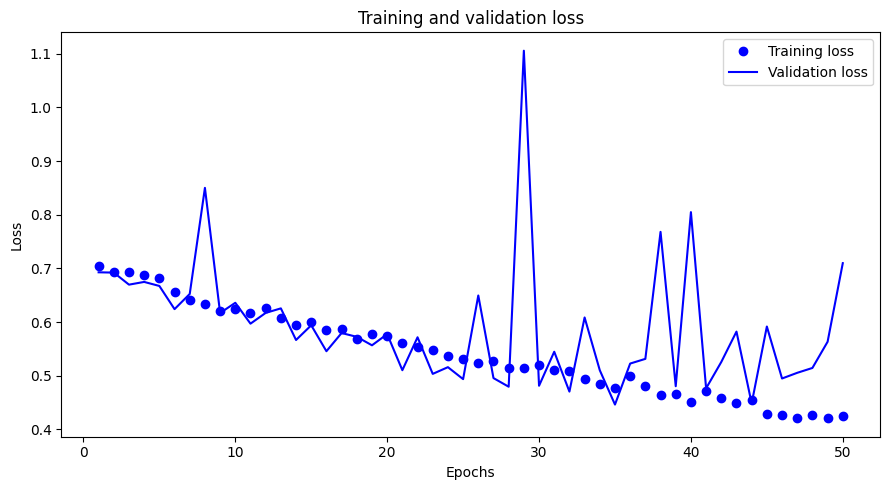

In [138]:
# plotting training-validation loss for vanilla CNN
plot_training_val_loss(history)

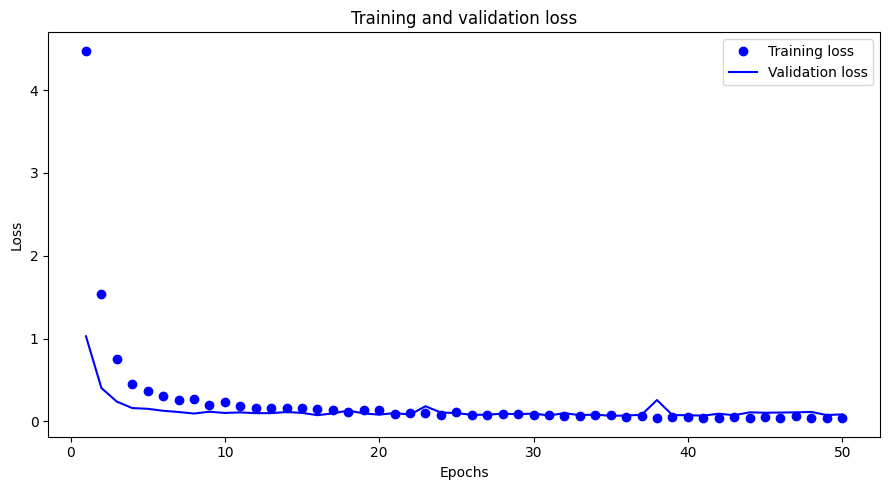

In [139]:
# plotting training-validation loss for Pre-trained VGG-16 model
plot_training_val_loss(VGG16_model_history)

## Plotting the Training and validation accuracy for Vanilla CNN and Pre-trained VGG-16 models

**Vanilla CNN**

1. There was **huge fluctuations in the validation accuracy**.
2. At **epoch 35**, the **validation accuracy** reached **its maximum**.
3. **After epoch 35**, the **validation accuracy started to decrease**.
4. So, the ideal epoch is 35. 

**Pre-trained VGG-16 models**

1. When **compared to Vanilla CNN**, **Pre-trained VGG-16 does not have many fluctuations** in **both training and validation accuracy**.
2. At **epoch 27**, the **validation accuracy is high**.
3. **After epoch 27** **there is no much difference in validation accuracy**.
4. so, the **ideal epoch is somewhere between epoch 24 and 27 after which the model started to overfit the data**.



In [140]:
# Function to plot the training and validation accuracy of models
def plot_training_val_accuracy(model_history):
    history_dict = model_history.history
    plt.figure(figsize=(9, 5))
    acc_values = history_dict["accuracy"]
    val_acc_values = history_dict["val_accuracy"]
    epochs = range(1, len(acc_values) + 1)
    plt.plot(epochs, acc_values, "bo", label="Training accuracy")
    plt.plot(epochs, val_acc_values, "b", label="Validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title(f"Training and validation accuracy")

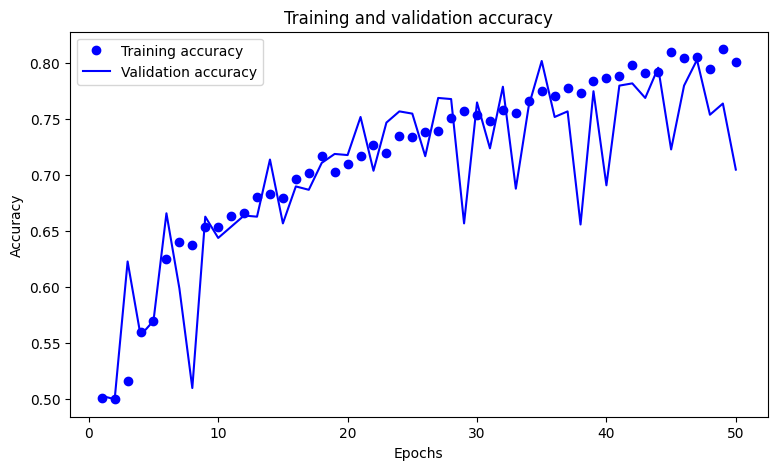

In [141]:
#plotting the training validation accuracy of Vanilla CNN
plot_training_val_accuracy(history)

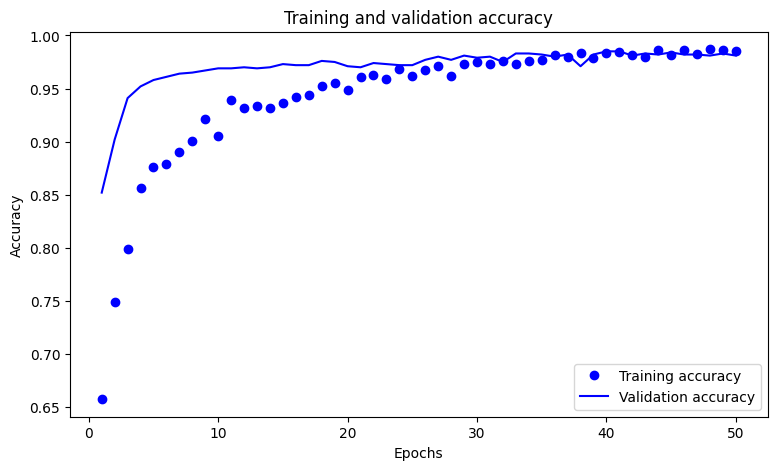

In [142]:
#plotting the training validation accuracy of Pre-trained VGG-16 model
plot_training_val_accuracy(VGG16_model_history)

## Evaluation on validation dataset with best weights of two models

### Validation Accuracy

**Vanilla CNN**

1. The **validation accuracy after 50 epochs is 70.5%** but **the best saved model produced an accuracy of 80.4% on validation dataset  with loss of 0.446**.

**Pre-trained VGG-16**

1. The **best saved model** produced a **validation accuracy of 98.2% with a validation loss of 0.068**. 
2. **After complete 50 epochs**, the **validation loss is 0.0855** which **some what high when compared to best saved model**.

In [27]:
val_images = dataset_images['Validation']
val_labels = dataset_labels['Validation']

In [29]:
# Calculating the accuracy,loss of the best saved model on validation dataset
best_Vanilla_CNN_model = keras.models.load_model(
    "./models/CNN_with_augmentation.keras")
val_loss, val_acc= best_Vanilla_CNN_model.evaluate(val_images,val_labels)
print(f"Validation loss of the best Vanilla CNN model: {val_loss:.3f}")
print(f"Validation accuracy of the best Vanilla CNN model: {val_acc:.3f}")

32/32 [==============================] - 6s 188ms/step - loss: 0.4461 - accuracy: 0.8040
Validation loss of the best Vanilla CNN model: 0.446
Validation accuracy of the best Vanilla CNN model: 0.804


In [30]:
# Calculating the accuracy,loss of the best saved model on validation dataset
best_VGG_16_CNN_model = keras.models.load_model(
    "./models/VGG16_fine_tuning.keras")
vgg_val_loss, vgg_val_acc= best_VGG_16_CNN_model.evaluate(val_images,val_labels)
print(f"Validation loss of the best Vanilla CNN model: {vgg_val_loss:.3f}")
print(f"Validation accuracy of the best Vanilla CNN model: {vgg_val_acc:.3f}")

32/32 [==============================] - 58s 2s/step - loss: 0.0674 - accuracy: 0.9820
Validation loss of the best Vanilla CNN model: 0.067
Validation accuracy of the best Vanilla CNN model: 0.982


In [41]:
# Predicting the probablities of each class on the validation dataset
val_pred_prob = best_Vanilla_CNN_model.predict(val_images)
# From the probabilities finding the class with the highest probability as predicted class label. 
# Here we have set the threshold to 0.5 
# if the probability is greater than 0.5, the image is classified as Dog with label 1.
# Other wise as Cat with label of 0.
val_pred = (val_pred_prob > 0.5).astype(int)

32/32 [==============================] - 6s 192ms/step


In [48]:
# Predicting the probablities of each class on the validation dataset
vgg_val_pred_prob = best_VGG_16_CNN_model.predict(val_images)
# From the probabilities finding the class with the highest probability as predicted class label. 
# Here we have set the threshold to 0.5 
# if the probability is greater than 0.5, the image is classified as Dog with label 1.
# Other wise as Cat with label of 0.
vgg_val_pred = (vgg_val_pred_prob > 0.5).astype(int)

32/32 [==============================] - 61s 2s/step


### Confusion Matrix on Validation Dataset

In [49]:
# Confusion matrix
cm_val = confusion_matrix(val_labels,val_pred)
print(cm_val)

[[386 114]
 [ 82 418]]


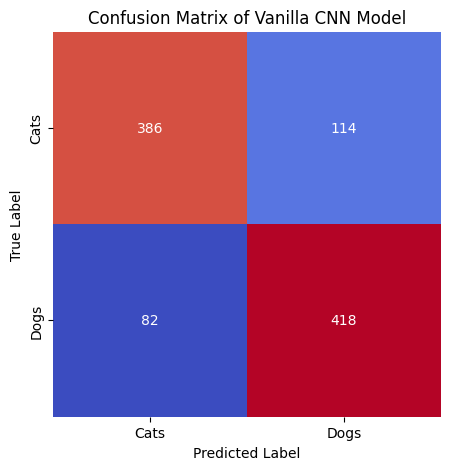

In [50]:
# plotting confusion matrix as a heat map
plt.figure(figsize=(5, 5))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='coolwarm', cbar=False, xticklabels=['Cats','Dogs'], yticklabels=['Cats','Dogs'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Vanilla CNN Model')
plt.show()

In [51]:
# Confusion matrix
vgg_cm_val = confusion_matrix(val_labels,vgg_val_pred)
print(vgg_cm_val)

[[492   8]
 [ 10 490]]


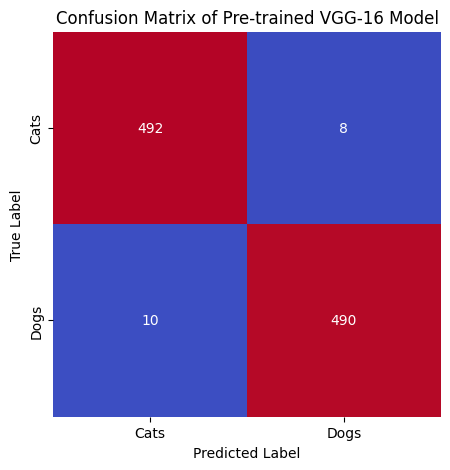

In [52]:
# plotting confusion matrix as a heat map
plt.figure(figsize=(5, 5))
sns.heatmap(vgg_cm_val, annot=True, fmt='d', cmap='coolwarm', cbar=False, xticklabels=['Cats','Dogs'], yticklabels=['Cats','Dogs'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Pre-trained VGG-16 Model')
plt.show()

### Classification Report for validation dataset

In [40]:
# Generating the classification report for validation dataset
validation_class_report = classification_report(val_labels,val_pred)
print(f"Classification Report for Vanilla CNN Model with best weights")
print(validation_class_report)

32/32 [==============================] - 6s 197ms/step
Classification Report for Vanilla CNN Model with best weights
              precision    recall  f1-score   support

           0       0.82      0.77      0.80       500
           1       0.79      0.84      0.81       500

    accuracy                           0.80      1000
   macro avg       0.81      0.80      0.80      1000
weighted avg       0.81      0.80      0.80      1000



In [53]:
# Generating the classification report for validation dataset
vgg_validation_class_report = classification_report(val_labels,vgg_val_pred)
print(f"Classification Report for Pre-trained VGG-16 CNN Model with best weights")
print(vgg_validation_class_report)

Classification Report for Pre-trained VGG-16 CNN Model with best weights
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       500
           1       0.98      0.98      0.98       500

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



### Precision Recall Curve for Validation dataset

In [54]:
precisions, recalls, thresholds = precision_recall_curve(
    val_labels, val_pred_prob)

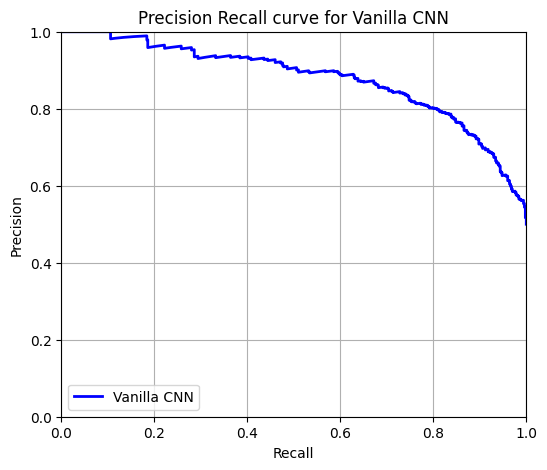

In [55]:
# Plotting the precision recall curve
plt.figure(figsize=(6, 5))

plt.plot(recalls, precisions, "b-", linewidth=2,
         label="Vanilla CNN")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.title("Precision Recall curve for Vanilla CNN")
plt.grid()
plt.legend(loc="lower left")

plt.show()

In [56]:
vgg_precisions, vgg_recalls, vgg_thresholds = precision_recall_curve(
    val_labels, vgg_val_pred_prob)

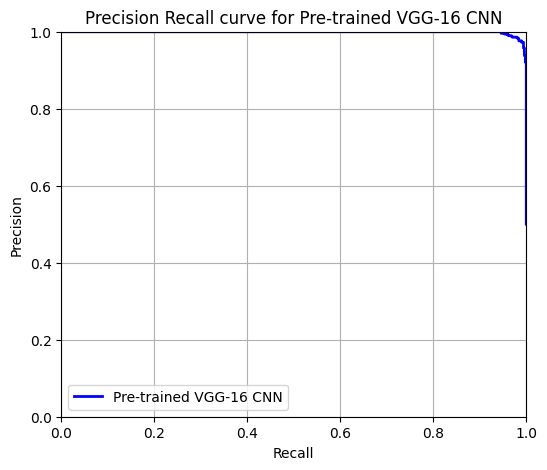

In [57]:
# Plotting the precision recall curve
plt.figure(figsize=(6, 5))

plt.plot(vgg_recalls, vgg_precisions, "b-", linewidth=2,
         label="Pre-trained VGG-16 CNN")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.title("Precision Recall curve for Pre-trained VGG-16 CNN")
plt.grid()
plt.legend(loc="lower left")
plt.show()

## Evaluation on Testing dataset with best weights of two models

In [58]:
test_images = dataset_images['Testing']
test_labels = dataset_labels['Testing']

In [60]:
test_loss, test_acc= best_Vanilla_CNN_model.evaluate(test_images,test_labels)
print(f"Testing loss of the best Vanilla CNN model: {test_loss:.3f}")
print(f"Testing accuracy of the best Vanilla CNN model: {test_acc:.3f}")

63/63 [==============================] - 12s 189ms/step - loss: 0.4833 - accuracy: 0.7790
Testing loss of the best Vanilla CNN model: 0.483
Testing accuracy of the best Vanilla CNN model: 0.779


In [61]:
vgg_test_loss, vgg_test_acc= best_VGG_16_CNN_model.evaluate(test_images,test_labels)
print(f"Testing loss of the best Vanilla CNN model: {vgg_test_loss:.3f}")
print(f"Testing accuracy of the best Vanilla CNN model: {vgg_test_acc:.3f}")

63/63 [==============================] - 121s 2s/step - loss: 0.1227 - accuracy: 0.9745
Testing loss of the best Vanilla CNN model: 0.123
Testing accuracy of the best Vanilla CNN model: 0.975


In [62]:
# Predicting the probablities of each class on the validation dataset
test_pred_prob = best_Vanilla_CNN_model.predict(test_images)
# From the probabilities finding the class with the highest probability as predicted class label. 
# Here we have set the threshold to 0.5 
# if the probability is greater than 0.5, the image is classified as Dog with label 1.
# Other wise as Cat with label of 0.
test_pred = (test_pred_prob > 0.5).astype(int)

63/63 [==============================] - 13s 199ms/step


In [63]:
# Predicting the probablities of each class on the validation dataset
vgg_test_pred_prob = best_VGG_16_CNN_model.predict(test_images)
# From the probabilities finding the class with the highest probability as predicted class label. 
# Here we have set the threshold to 0.5 
# if the probability is greater than 0.5, the image is classified as Dog with label 1.
# Other wise as Cat with label of 0.
vgg_test_pred = (vgg_test_pred_prob > 0.5).astype(int)

63/63 [==============================] - 121s 2s/step


### Confusion Matrix on Testing Dataset

In [64]:
# Confusion matrix
cm_test = confusion_matrix(test_labels,test_pred)
print(cm_test)

[[735 265]
 [177 823]]


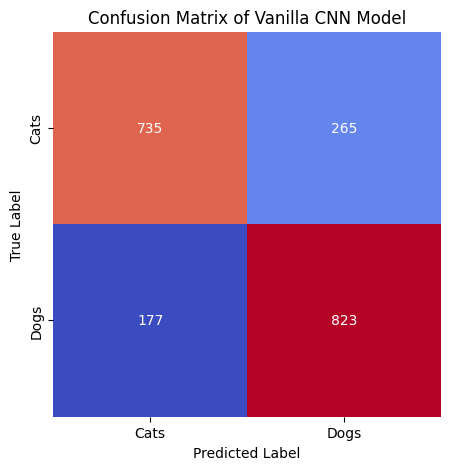

In [65]:
# plotting confusion matrix as a heat map
plt.figure(figsize=(5, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='coolwarm', cbar=False, xticklabels=['Cats','Dogs'], yticklabels=['Cats','Dogs'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Vanilla CNN Model')
plt.show()

In [66]:
# Confusion matrix
vgg_cm_test = confusion_matrix(test_labels,vgg_test_pred)
print(vgg_cm_test)

[[980  20]
 [ 31 969]]


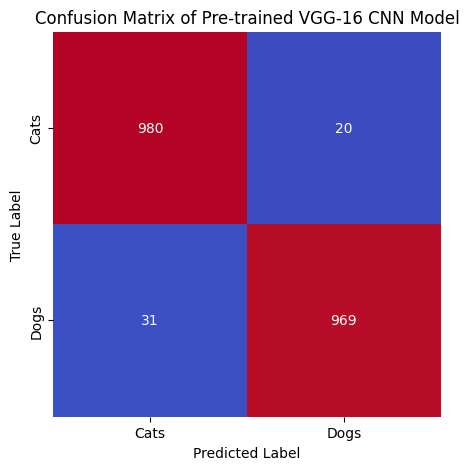

In [67]:
# plotting confusion matrix as a heat map
plt.figure(figsize=(5, 5))
sns.heatmap(vgg_cm_test, annot=True, fmt='d', cmap='coolwarm', cbar=False, xticklabels=['Cats','Dogs'], yticklabels=['Cats','Dogs'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Pre-trained VGG-16 CNN Model')
plt.show()

### Classification Report for Testing dataset

In [68]:
# Generating the classification report for validation dataset
testing_class_report = classification_report(test_labels,test_pred)
print(f"Classification Report for Vanilla CNN Model with best weights")
print(testing_class_report)

Classification Report for Vanilla CNN Model with best weights
              precision    recall  f1-score   support

           0       0.81      0.73      0.77      1000
           1       0.76      0.82      0.79      1000

    accuracy                           0.78      2000
   macro avg       0.78      0.78      0.78      2000
weighted avg       0.78      0.78      0.78      2000



In [69]:
# Generating the classification report for validation dataset
vgg_testing_class_report = classification_report(test_labels,vgg_test_pred)
print(f"Classification Report for Pre-trained VGG-16 CNN Model with best weights")
print(vgg_testing_class_report)

Classification Report for Pre-trained VGG-16 CNN Model with best weights
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1000
           1       0.98      0.97      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



### Precision Recall Curve for Testing dataset

In [70]:
test_precisions, test_recalls, test_thresholds = precision_recall_curve(
    test_labels, test_pred_prob)

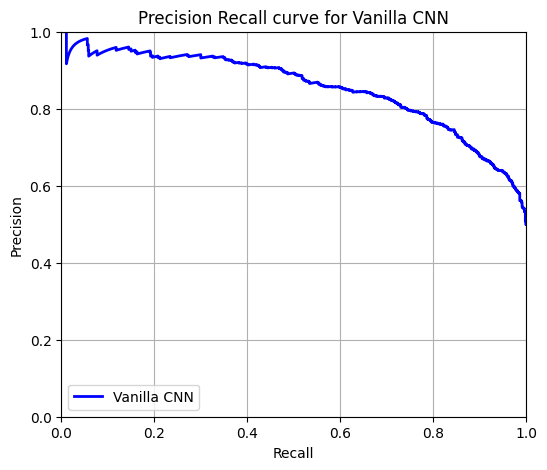

In [71]:
# Plotting the precision recall curve
plt.figure(figsize=(6, 5))

plt.plot(test_recalls, test_precisions, "b-", linewidth=2,
         label="Vanilla CNN")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.title("Precision Recall curve for Vanilla CNN")
plt.grid()
plt.legend(loc="lower left")

plt.show()

In [72]:
vgg_test_precisions, vgg_test_recalls, vgg_test_thresholds = precision_recall_curve(
    test_labels, vgg_test_pred_prob)

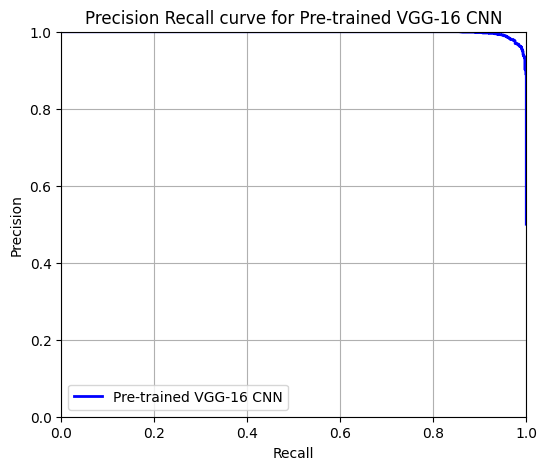

In [73]:
# Plotting the precision recall curve
plt.figure(figsize=(6, 5))
plt.plot(vgg_test_recalls, vgg_test_precisions, "b-", linewidth=2,
         label="Pre-trained VGG-16 CNN")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.title("Precision Recall curve for Pre-trained VGG-16 CNN")
plt.grid()
plt.legend(loc="lower left")
plt.show()

## Conclusion